In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import zscore
import matplotlib.pyplot as plt 
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [4]:
data = pd.read_excel('dados_relatorio_final.xlsx')

In [5]:
data.head()

,time,IBOV,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,...,RAIL3,SANB11,SBSP3,SMLS3,TIMP3,UGPA3,USIM5,VALE3,VIVT4,WEGE3
0,2017-01-02,59589,15.09,24.18,15.98,15.94,20.38,12.60,47.90,30.82,...,6.12,24.27,25.46,36.27,7.21,31.13,3.96,22.79,34.80,10.99
1,2017-01-03,61814,15.39,25.28,16.63,16.62,21.11,13.13,49.50,32.58,...,6.19,25.13,25.76,38.38,7.52,31.63,4.17,23.80,35.16,11.54
2,2017-01-04,61589,15.27,25.15,16.62,16.51,21.78,12.85,48.91,32.03,...,6.19,25.25,26.50,38.46,7.67,31.13,4.42,23.37,35.01,11.26
3,2017-01-05,62071,15.36,25.09,16.72,16.69,21.34,13.49,48.53,32.41,...,6.20,25.17,26.58,38.32,7.77,31.31,4.47,24.26,34.42,11.23
4,2017-01-06,61665,15.23,25.36,16.84,16.80,21.01,13.25,46.22,31.77,...,6.36,25.06,26.19,36.62,7.67,31.17,4.34,23.61,34.51,11.33


In [26]:
class senninha_long_and_short():
    def __init__(self,dados,t1,t2, financeiro_inicial, zs_l):
        #temos o par de tickers, os dados históricos de preço, e as variações históricas.
        self.zs_critico = zs_l
        self.t1, self.t2 = t1,t2
        self.dados = dados[['time',t1,t2]]
        self.dados_var = dados[[t1,t2]].pct_change()[1:]
        self.dados = self.dados[1:]
        self.s1, self.s2 = self.dados[self.t1], self.dados[self.t2]
        self.s1_var, self.s2_var = self.dados_var[self.t1], self.dados_var[self.t2]
        self.financeiro = financeiro_inicial
        #variaveis iniciais para tradar pares
        self.posicionado = 0
        self.compra_s1 = 0
        self.venda_s2 = 0
        #desempenho ao longo do tempo 
        self.l_resultado = []
        self.l_pct_operacoes = []
          
    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs, b
    
    def print_resultados(self, tipo, r): #rlong,rshort,result
        if tipo == 'entrada':
            print(f'entrou | V1 {self.venda_s1:.2f} X {self.v1} | C2 {self.compra_s2:.2f} X {self.v2}')
        elif tipo == 'saida':
            print(f'saiu   | C1 {self.compra_s1:.2f} X {self.v1} | V2 {self.venda_s2:.2f} X {self.v2}')
        elif tipo == 'resultado':
            print(f'result | s1 {r[0]:.2f} | s2 {r[1]:.2f} | l/p = {r[2]:.2f}\n')
    
    def condicoes_operar(self, zs_atual, cotacao1, cotacao2):
        if zs_atual >= self.zs_critico and self.posicionado == 0:
            razao = cotacao1/cotacao2
            volume = (self.financeiro/2)//cotacao1
            self.v1, self.v2 = int(volume), int(razao*volume)
            #definiu o numero de ações que comprará de cada
            self.venda_s1 = cotacao1*self.v1
            self.compra_s2  = cotacao2*self.v2 
            self.valor_total_trade = self.venda_s1+self.compra_s2
            self.print_resultados('entrada',r=None)
            self.posicionado = 1
        elif zs_atual <= 0.08 and self.posicionado == 1:
            self.posicionado = 0            
            #encerra posicao
            self.compra_s1 = cotacao1*self.v1
            self.venda_s2  = cotacao2*self.v2 
            self.print_resultados('saida',r=None)
            #resultado
            resultado_long  = self.venda_s1 - self.compra_s1
            resultado_short = self.venda_s2 - self.compra_s2
            resultado = resultado_long + resultado_short
            pct_operacao = (resultado/self.valor_total_trade)*100
            #resultados ao longo do tempo
            self.l_pct_operacoes.append(pct_operacao)
            self.l_resultado.append(resultado)
            self.print_resultados('resultado',[resultado_long,resultado_short,resultado])
            self.financeiro += resultado
            #reseta valor em carteira de cada ação
            self.compra_s1, self.venda_s1, self.compra_s2 ,self.venda_s2,  = 0, 0, 0, 0
            resultado, resultado_long, resultado_short = 0, 0, 0
            
    def loop_operador(self, window_size):
        c = 0
        for index in range(window_size, len(self.s1)):
            #stock data in the window range
            s1_var_w, s2_var_w = self.s1_var[c:index], self.s2_var[c:index]
            preco_s1, preco_s2 = self.s1[self.dados.index == index].values[0], self.s2[self.dados.index == index].values[0]
            #calculates the zscore of the spread
            resultado_funcao = self.calcula_zscore_spread(s1_var_w, s2_var_w)
            zs, beta = resultado_funcao[0], resultado_funcao[1]
            self.condicoes_operar(zs_atual=zs, cotacao1=preco_s1, cotacao2=preco_s2)   
            c+=1

In [28]:
zsl = 1.1
dic_dados_pares = {}

tickers = [['VALE3','ITSA4'],['ECOR3','GOAU4'],['CSNA3','MRFG3'],['QUAL3','USIM5']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']
for i in tickers:
    dic_dados_pares[str(i)] = senninha_long_and_short(data,i[0], i[1], 1000,zs_l = zsl)
    dic_dados_pares[str(i)].loop_operador(window_size=45)

entrou | V1 484.80 X 16 | C2 482.40 X 67
saiu   | C1 473.28 X 16 | V2 482.40 X 67
result | s1 11.52 | s2 0.00 | l/p = 11.52

entrou | V1 481.14 X 18 | C2 480.93 X 69
saiu   | C1 478.62 X 18 | V2 476.79 X 69
result | s1 2.52 | s2 -4.14 | l/p = -1.62

entrou | V1 498.80 X 20 | C2 497.52 X 72
saiu   | C1 485.00 X 20 | V2 493.20 X 72
result | s1 13.80 | s2 -4.32 | l/p = 9.48

entrou | V1 487.54 X 19 | C2 487.20 X 70
saiu   | C1 503.50 X 19 | V2 487.90 X 70
result | s1 -15.96 | s2 0.70 | l/p = -15.26

entrou | V1 501.60 X 20 | C2 499.84 X 71
saiu   | C1 474.00 X 20 | V2 499.84 X 71
result | s1 27.60 | s2 0.00 | l/p = 27.60

entrou | V1 511.35 X 21 | C2 506.80 X 70
saiu   | C1 511.14 X 21 | V2 505.40 X 70
result | s1 0.21 | s2 -1.40 | l/p = -1.19

entrou | V1 492.20 X 20 | C2 489.72 X 66
saiu   | C1 498.20 X 20 | V2 491.04 X 66
result | s1 -6.00 | s2 1.32 | l/p = -4.68

entrou | V1 487.92 X 19 | C2 483.00 X 75
saiu   | C1 495.90 X 19 | V2 474.00 X 75
result | s1 -7.98 | s2 -9.00 | l/p = -16.

entrou | V1 467.50 X 10 | C2 465.48 X 36
saiu   | C1 465.60 X 10 | V2 464.40 X 36
result | s1 1.90 | s2 -1.08 | l/p = 0.82

entrou | V1 468.80 X 10 | C2 460.28 X 37
saiu   | C1 456.30 X 10 | V2 468.79 X 37
result | s1 12.50 | s2 8.51 | l/p = 21.01

entrou | V1 508.20 X 11 | C2 496.28 X 38
saiu   | C1 502.37 X 11 | V2 499.70 X 38
result | s1 5.83 | s2 3.42 | l/p = 9.25

entrou | V1 517.11 X 11 | C2 508.44 X 38
saiu   | C1 514.69 X 11 | V2 502.74 X 38
result | s1 2.42 | s2 -5.70 | l/p = -3.28

entrou | V1 494.10 X 10 | C2 483.74 X 38
saiu   | C1 497.70 X 10 | V2 498.18 X 38
result | s1 -3.60 | s2 14.44 | l/p = 10.84

entrou | V1 502.50 X 10 | C2 501.60 X 38
saiu   | C1 500.10 X 10 | V2 500.84 X 38
result | s1 2.40 | s2 -0.76 | l/p = 1.64

entrou | V1 469.62 X 9 | C2 467.25 X 35
saiu   | C1 475.38 X 9 | V2 472.15 X 35
result | s1 -5.76 | s2 4.90 | l/p = -0.86

entrou | V1 482.31 X 9 | C2 479.50 X 35
saiu   | C1 482.40 X 9 | V2 477.40 X 35
result | s1 -0.09 | s2 -2.10 | l/p = -2.19

entrou

entrou | V1 451.41 X 41 | C2 451.08 X 63
saiu   | C1 450.59 X 41 | V2 435.96 X 63
result | s1 0.82 | s2 -15.12 | l/p = -14.30

entrou | V1 448.95 X 41 | C2 446.67 X 63
saiu   | C1 448.95 X 41 | V2 446.67 X 63
result | s1 0.00 | s2 0.00 | l/p = 0.00

entrou | V1 442.64 X 44 | C2 436.15 X 61
saiu   | C1 435.60 X 44 | V2 445.30 X 61
result | s1 7.04 | s2 9.15 | l/p = 16.19

entrou | V1 451.20 X 48 | C2 445.20 X 60
saiu   | C1 440.16 X 48 | V2 441.60 X 60
result | s1 11.04 | s2 -3.60 | l/p = 7.44

entrou | V1 457.08 X 52 | C2 452.20 X 68
saiu   | C1 449.80 X 52 | V2 437.92 X 68
result | s1 7.28 | s2 -14.28 | l/p = -7.00

entrou | V1 453.55 X 47 | C2 451.50 X 70
saiu   | C1 464.83 X 47 | V2 470.40 X 70
result | s1 -11.28 | s2 18.90 | l/p = 7.62

entrou | V1 461.12 X 44 | C2 456.06 X 66
saiu   | C1 479.16 X 44 | V2 467.94 X 66
result | s1 -18.04 | s2 11.88 | l/p = -6.16

entrou | V1 452.79 X 43 | C2 452.48 X 64
saiu   | C1 455.80 X 43 | V2 449.28 X 64
result | s1 -3.01 | s2 -3.20 | l/p = -6.

entrou | V1 555.00 X 60 | C2 554.88 X 96
saiu   | C1 555.60 X 60 | V2 578.88 X 96
result | s1 -0.60 | s2 24.00 | l/p = 23.40

entrou | V1 560.86 X 58 | C2 557.65 X 95
saiu   | C1 528.96 X 58 | V2 551.00 X 95
result | s1 31.90 | s2 -6.65 | l/p = 25.25

entrou | V1 580.80 X 60 | C2 575.00 X 92
saiu   | C1 570.60 X 60 | V2 559.36 X 92
result | s1 10.20 | s2 -15.64 | l/p = -5.44

entrou | V1 574.62 X 61 | C2 569.60 X 89
saiu   | C1 529.48 X 61 | V2 557.14 X 89
result | s1 45.14 | s2 -12.46 | l/p = 32.68

entrou | V1 595.35 X 63 | C2 591.60 X 102
saiu   | C1 604.17 X 63 | V2 576.30 X 102
result | s1 -8.82 | s2 -15.30 | l/p = -24.12

entrou | V1 581.24 X 44 | C2 581.03 X 97
saiu   | C1 635.36 X 44 | V2 573.27 X 97
result | s1 -54.12 | s2 -7.76 | l/p = -61.88

entrou | V1 547.20 X 36 | C2 542.88 X 87
saiu   | C1 526.32 X 36 | V2 532.44 X 87
result | s1 20.88 | s2 -10.44 | l/p = 10.44

entrou | V1 555.56 X 38 | C2 550.16 X 92
saiu   | C1 575.70 X 38 | V2 550.16 X 92
result | s1 -20.14 | s2 0.0

saiu   | C1 502.50 X 30 | V2 516.78 X 58
result | s1 5.10 | s2 17.40 | l/p = 22.50

entrou | V1 522.36 X 36 | C2 514.71 X 63
saiu   | C1 498.60 X 36 | V2 491.40 X 63
result | s1 23.76 | s2 -23.31 | l/p = 0.45

entrou | V1 529.23 X 39 | C2 526.82 X 71
saiu   | C1 538.20 X 39 | V2 557.35 X 71
result | s1 -8.97 | s2 30.53 | l/p = 21.56

entrou | V1 535.42 X 38 | C2 529.28 X 64
saiu   | C1 525.92 X 38 | V2 517.76 X 64
result | s1 9.50 | s2 -11.52 | l/p = -2.02

entrou | V1 537.35 X 55 | C2 531.76 X 68
saiu   | C1 600.05 X 55 | V2 598.40 X 68
result | s1 -62.70 | s2 66.64 | l/p = 3.94

entrou | V1 542.38 X 47 | C2 536.80 X 55
saiu   | C1 534.39 X 47 | V2 537.35 X 55
result | s1 7.99 | s2 0.55 | l/p = 8.54

entrou | V1 548.32 X 46 | C2 540.60 X 53
saiu   | C1 571.32 X 46 | V2 527.35 X 53
result | s1 -23.00 | s2 -13.25 | l/p = -36.25

entrou | V1 528.00 X 44 | C2 525.25 X 55
saiu   | C1 528.00 X 44 | V2 501.05 X 55
result | s1 0.00 | s2 -24.20 | l/p = -24.20

entrou | V1 511.72 X 44 | C2 510.

['VALE3', 'ITSA4']: 1025.07
['ECOR3', 'GOAU4']: 914.52
['CSNA3', 'MRFG3']: 1049.67
['QUAL3', 'USIM5']: 782.06


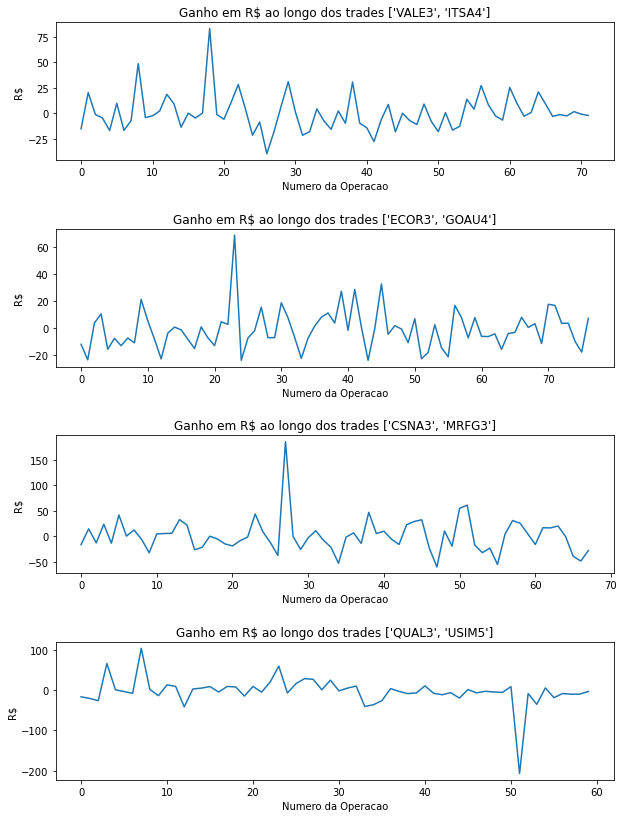

In [14]:
fig = plt.figure(figsize=(10, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
contador1 = 1

for k,v in dic_dados_pares.items():
    print(f'{k}: {v.financeiro:.2f}')
    plt.subplot(8, 1, contador1)
    plt.title('Ganho em R$ ao longo dos trades '+ k)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    plt.plot(v.l_resultado)
    contador1 += 1

In [17]:
dados = pd.read_excel('C:/Users/danie/Desktop/mql_python/todos_diretorios_desenvolvimento_projeto/Relatório 1/dados_relatorio.xlsx')[2:] #windows

In [20]:
dic_dados_pares = {}

In [22]:
zsl = 1.1
tickers = [['close VALE3','close ITSA4'],['close ECOR3','close GOAU4'],['close CSNA3','close MRFG3'],['close QUAL3','close USIM5']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']
for i in tickers:
    dic_dados_pares[str(i)] = senninha_long_and_short(dados,i[0], i[1], 1000,zs_l = zsl)
    dic_dados_pares[str(i)].loop_operador(window_size=75)

['close VALE3', 'close ITSA4']: 1549.93
['close ECOR3', 'close GOAU4']: 2216.38
['close CSNA3', 'close MRFG3']: 2273.96
['close QUAL3', 'close USIM5']: 3288.94


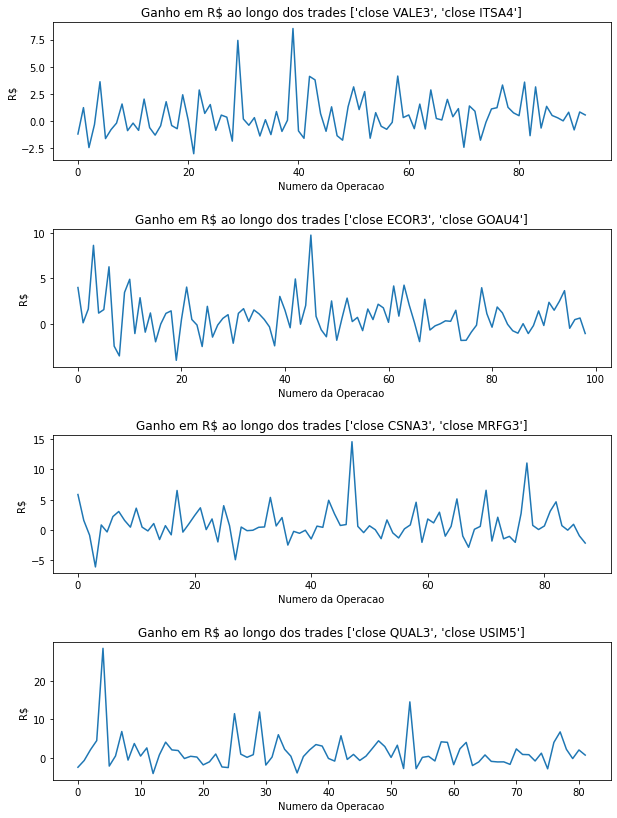

In [24]:
fig = plt.figure(figsize=(10, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
contador1 = 1

for k,v in dic_dados_pares.items():
    print(f'{k}: {v.financeiro:.2f}')
    plt.subplot(8, 1, contador1)
    plt.title('Ganho em R$ ao longo dos trades '+ k)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    plt.plot(v.l_pct_operacoes)
    contador1 += 1

In [25]:
for k,v in dic_dados_pares.items():
    lista_dias_series = pd.Series(v.l_pct_operacoes)
    print(k,lista_dias_series.describe(),'\n |||||||||||||||||||||||||||||||||||||||||||')  

['close VALE3', 'close ITSA4'] count    93.000000
mean      0.513201
std       1.913653
min      -3.048212
25%      -0.792977
50%       0.283654
75%       1.282946
max       8.517679
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
['close ECOR3', 'close GOAU4'] count    99.000000
mean      0.836786
std       2.230047
min      -4.019620
25%      -0.412970
50%       0.466728
75%       1.697500
max       9.730274
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
['close CSNA3', 'close MRFG3'] count    88.000000
mean      0.985389
std       2.907962
min      -6.130699
25%      -0.465914
50%       0.580485
75%       1.866467
max      14.585857
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
['close QUAL3', 'close USIM5'] count    82.000000
mean      1.566392
std       4.424725
min      -4.057963
25%      -0.806423
50%       0.601992
75%       2.535873
max      28.343123
dtype: float64 
 |||||||||||||||||||||||||||||||||||||||||||
